(1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 280/280 [00:00<00:00, 6118.86 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_35656\4

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.628900,0.627774,0.682143,0.553245
2,0.639800,0.627775,0.682143,0.553245
3,0.612200,0.625640,0.682143,0.553245
4,0.647300,0.625553,0.682143,0.553245
5,0.646800,0.626853,0.682143,0.553245
6,0.617300,0.626720,0.682143,0.553245
7,0.597800,0.626594,0.682143,0.553245
8,0.581000,0.626621,0.682143,0.553245
9,0.635600,0.627521,0.682143,0.553245
10,0.657100,0.628432,0.682143,0.553245


Evaluation results: {'eval_loss': 0.6284319162368774, 'eval_accuracy': 0.6821428571428572, 'eval_f1': 0.5532453745829542, 'eval_runtime': 3.4434, 'eval_samples_per_second': 81.316, 'eval_steps_per_second': 5.227, 'epoch': 10.0}


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      1.00      0.81       191
    Positive       0.00      0.00      0.00        89

    accuracy                           0.68       280
   macro avg       0.34      0.50      0.41       280
weighted avg       0.47      0.68      0.55       280



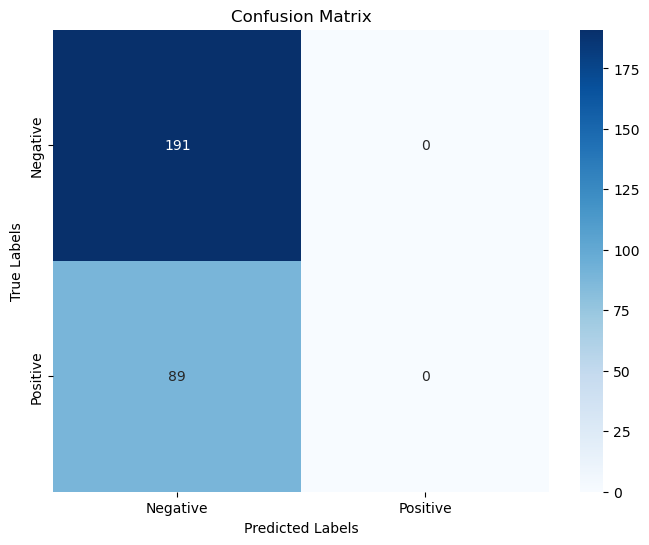

In [1]:
import pandas as pd

df = pd.read_csv("data/bangla_political_comments.csv")

print(df.shape)
print(df.head())

df.isnull().sum()

X = df['Comment']
y = df['Label']

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

le = LabelEncoder()
y_en = le.fit_transform(y)

from datasets import Dataset

data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_en}))
data = data.train_test_split(test_size=0.2, seed=42)

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

device = torch.device('cuda')
model_name = 'google/electra-base-discriminator'

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.to(device)
model.eval()

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)


data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text'])
data = data.rename_column('label', 'labels')
data.set_format('torch')

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

trainer.train()

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

import numpy as np

predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids



report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load Data
df = pd.read_csv("data/bangla_political_comments.csv")
print("Dataset Shape:", df.shape)
print(df.head())
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
X, y = df['Comment'], df['Label']
le = LabelEncoder()
y_en = le.fit_transform(y)
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_en}))
data = data.train_test_split(test_size=0.2, seed=42)

# Tokenization
model_name = 'google/electra-base-discriminator'
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)
data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text'])
data = data.rename_column('label', 'labels')
data.set_format('torch')

# Hyperparameter Grid
param_grid = {
    "learning_rate": [2e-5, 3e-5, 5e-5],
    "batch_size": [16],
    "epochs": [3, 5, 7, 10],
    "weight_decay": [0.01, 0.1]
}

best_params = None
best_score = 0

device = torch.device('cuda')
for lr in param_grid["learning_rate"]:
    for bs in param_grid["batch_size"]:
        for ep in param_grid["epochs"]:
            for wd in param_grid["weight_decay"]:
                print(f"Training with lr={lr}, bs={bs}, epochs={ep}, weight_decay={wd}")
                
                model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
                model.to(device)
                
                training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=lr,
                    per_device_train_batch_size=bs,
                    per_device_eval_batch_size=bs,
                    num_train_epochs=ep,
                    weight_decay=wd,
                    logging_dir="./logs",
                    save_strategy='no',
                    report_to=[]
                )
                
                trainer = Trainer(
                    model=model,
                    args=training_args,
                    train_dataset=data['train'],
                    eval_dataset=data['test'],
                    tokenizer=tokenizer,
                    compute_metrics=lambda eval_pred: {
                        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
                        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
                    }
                )
                
                trainer.train()
                eval_results = trainer.evaluate()
                score = eval_results["eval_accuracy"]
                
                if score > best_score:
                    best_score = score
                    best_params = {"learning_rate": lr, "batch_size": bs, "epochs": ep, "weight_decay": wd}

print("Best hyperparameters: ", best_params)


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Map: 100%|██████████| 280/280 [00:00<00:00, 5965.63 examples/s]


Training with lr=2e-05, bs=16, epochs=3, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617829,0.692857,0.567149
2,No log,0.623232,0.692857,0.567149
3,No log,0.617673,0.692857,0.567149


Training with lr=2e-05, bs=16, epochs=3, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617501,0.692857,0.567149
2,No log,0.619973,0.692857,0.567149
3,No log,0.617133,0.692857,0.567149


Training with lr=2e-05, bs=16, epochs=5, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617589,0.692857,0.567149
2,No log,0.622498,0.692857,0.567149
3,No log,0.617508,0.692857,0.567149
4,No log,0.619816,0.692857,0.567149
5,No log,0.618426,0.692857,0.567149


Training with lr=2e-05, bs=16, epochs=5, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.619823,0.692857,0.567149
2,No log,0.626838,0.692857,0.567149
3,No log,0.627315,0.692857,0.567149
4,No log,0.616339,0.692857,0.567149
5,No log,0.610660,0.692857,0.567149


Training with lr=2e-05, bs=16, epochs=7, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.618868,0.692857,0.567149
2,No log,0.622528,0.692857,0.567149
3,No log,0.617756,0.692857,0.567149
4,No log,0.625063,0.692857,0.567149
5,No log,0.627608,0.692857,0.567149
6,No log,0.617130,0.692857,0.567149
7,No log,0.618788,0.692857,0.567149


Training with lr=2e-05, bs=16, epochs=7, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.615853,0.692857,0.567149
2,No log,0.636810,0.692857,0.567149
3,No log,0.617827,0.692857,0.567149
4,No log,0.616706,0.692857,0.567149
5,No log,0.623281,0.692857,0.567149
6,No log,0.615055,0.692857,0.567149
7,No log,0.618920,0.692857,0.567149


Training with lr=2e-05, bs=16, epochs=10, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.616562,0.692857,0.567149
2,No log,0.616791,0.692857,0.567149
3,No log,0.617017,0.692857,0.567149
4,No log,0.617521,0.692857,0.567149
5,No log,0.624033,0.692857,0.567149
6,No log,0.616999,0.692857,0.567149
7,No log,0.617047,0.692857,0.567149
8,0.614600,0.617809,0.692857,0.567149
9,0.614600,0.617055,0.692857,0.567149
10,0.614600,0.617302,0.692857,0.567149


Training with lr=2e-05, bs=16, epochs=10, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.615494,0.692857,0.567149
2,No log,0.617125,0.692857,0.567149
3,No log,0.617118,0.692857,0.567149
4,No log,0.612283,0.692857,0.567149
5,No log,0.647593,0.692857,0.567149
6,No log,0.602385,0.692857,0.567149
7,No log,0.601710,0.692857,0.567149
8,0.605700,0.639633,0.696429,0.575409
9,0.605700,0.612454,0.710714,0.612314
10,0.605700,0.582281,0.728571,0.683045


Training with lr=3e-05, bs=16, epochs=3, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.620842,0.692857,0.567149
2,No log,0.619807,0.692857,0.567149
3,No log,0.616821,0.692857,0.567149


Training with lr=3e-05, bs=16, epochs=3, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.616857,0.692857,0.567149
2,No log,0.620856,0.692857,0.567149
3,No log,0.617712,0.692857,0.567149


Training with lr=3e-05, bs=16, epochs=5, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617506,0.692857,0.567149
2,No log,0.622386,0.692857,0.567149
3,No log,0.617825,0.692857,0.567149
4,No log,0.622090,0.692857,0.567149
5,No log,0.619493,0.692857,0.567149


Training with lr=3e-05, bs=16, epochs=5, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.626723,0.692857,0.567149
2,No log,0.620293,0.692857,0.567149
3,No log,0.624265,0.692857,0.567149
4,No log,0.619851,0.692857,0.567149
5,No log,0.621184,0.692857,0.567149


Training with lr=3e-05, bs=16, epochs=7, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.618729,0.692857,0.567149
2,No log,0.617148,0.692857,0.567149
3,No log,0.618763,0.692857,0.567149
4,No log,0.619917,0.692857,0.567149
5,No log,0.626001,0.692857,0.567149
6,No log,0.613919,0.692857,0.567149
7,No log,0.611088,0.692857,0.567149


Training with lr=3e-05, bs=16, epochs=7, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617884,0.692857,0.567149
2,No log,0.619473,0.692857,0.567149
3,No log,0.618839,0.692857,0.567149
4,No log,0.623411,0.692857,0.567149
5,No log,0.624551,0.692857,0.567149
6,No log,0.618830,0.692857,0.567149
7,No log,0.619576,0.692857,0.567149


Training with lr=3e-05, bs=16, epochs=10, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617232,0.692857,0.567149
2,No log,0.620544,0.692857,0.567149
3,No log,0.616798,0.692857,0.567149
4,No log,0.616964,0.692857,0.567149
5,No log,0.626274,0.692857,0.567149
6,No log,0.616817,0.692857,0.567149
7,No log,0.617085,0.692857,0.567149
8,0.615200,0.618890,0.692857,0.567149
9,0.615200,0.617566,0.692857,0.567149
10,0.615200,0.618237,0.692857,0.567149


Training with lr=3e-05, bs=16, epochs=10, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.616829,0.692857,0.567149
2,No log,0.618664,0.692857,0.567149
3,No log,0.616787,0.692857,0.567149
4,No log,0.618167,0.692857,0.567149
5,No log,0.625592,0.692857,0.567149
6,No log,0.616928,0.692857,0.567149
7,No log,0.616839,0.692857,0.567149
8,0.614900,0.617862,0.692857,0.567149
9,0.614900,0.616996,0.692857,0.567149
10,0.614900,0.617492,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=3, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.618097,0.692857,0.567149
2,No log,0.617957,0.692857,0.567149
3,No log,0.616736,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=3, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.618062,0.692857,0.567149
2,No log,0.622268,0.692857,0.567149
3,No log,0.617878,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=5, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.616243,0.692857,0.567149
2,No log,0.617354,0.692857,0.567149
3,No log,0.616894,0.692857,0.567149
4,No log,0.617384,0.692857,0.567149
5,No log,0.616880,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=5, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.620251,0.692857,0.567149
2,No log,0.617003,0.692857,0.567149
3,No log,0.616691,0.692857,0.567149
4,No log,0.618411,0.692857,0.567149
5,No log,0.617368,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=7, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617031,0.692857,0.567149
2,No log,0.616892,0.692857,0.567149
3,No log,0.616940,0.692857,0.567149
4,No log,0.617520,0.692857,0.567149
5,No log,0.624240,0.692857,0.567149
6,No log,0.616902,0.692857,0.567149
7,No log,0.617586,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=7, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.619362,0.692857,0.567149
2,No log,0.617475,0.692857,0.567149
3,No log,0.617671,0.692857,0.567149
4,No log,0.618050,0.692857,0.567149
5,No log,0.625572,0.692857,0.567149
6,No log,0.616964,0.692857,0.567149
7,No log,0.617577,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=10, weight_decay=0.01


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617797,0.692857,0.567149
2,No log,0.616871,0.692857,0.567149
3,No log,0.620272,0.692857,0.567149
4,No log,0.617902,0.692857,0.567149
5,No log,0.636435,0.692857,0.567149
6,No log,0.617200,0.692857,0.567149
7,No log,0.616937,0.692857,0.567149
8,0.615300,0.618822,0.692857,0.567149
9,0.615300,0.617157,0.692857,0.567149
10,0.615300,0.617735,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=10, weight_decay=0.1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\2147472996.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617504,0.692857,0.567149
2,No log,0.617343,0.692857,0.567149
3,No log,0.618057,0.692857,0.567149
4,No log,0.617665,0.692857,0.567149
5,No log,0.632519,0.692857,0.567149
6,No log,0.617214,0.692857,0.567149
7,No log,0.616875,0.692857,0.567149
8,0.615600,0.618211,0.692857,0.567149
9,0.615600,0.617056,0.692857,0.567149
10,0.615600,0.617625,0.692857,0.567149


Best hyperparameters:  {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 10, 'weight_decay': 0.1}


(1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 280/280 [00:00<00:00, 6075.18 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_50540\4291020808.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.628500,0.632175,0.682143,0.553245
2,0.648200,0.631232,0.682143,0.553245
3,0.615500,0.626803,0.682143,0.553245
4,0.644700,0.628905,0.682143,0.553245
5,0.640900,0.629019,0.682143,0.553245
6,0.615300,0.627327,0.682143,0.553245
7,0.577500,0.630455,0.682143,0.553245
8,0.558200,0.638519,0.682143,0.553245
9,0.606600,0.616134,0.682143,0.553245
10,0.618800,0.617313,0.682143,0.553245


Evaluation results: {'eval_loss': 0.6173128485679626, 'eval_accuracy': 0.6821428571428572, 'eval_f1': 0.5532453745829542, 'eval_runtime': 3.2948, 'eval_samples_per_second': 84.983, 'eval_steps_per_second': 5.463, 'epoch': 10.0}


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      1.00      0.81       191
    Positive       0.00      0.00      0.00        89

    accuracy                           0.68       280
   macro avg       0.34      0.50      0.41       280
weighted avg       0.47      0.68      0.55       280



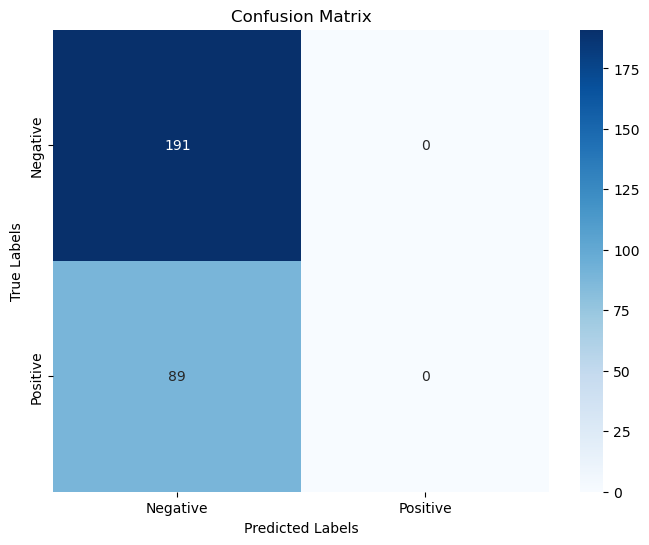

In [2]:
import pandas as pd

df = pd.read_csv("data/bangla_political_comments.csv")

print(df.shape)
print(df.head())

df.isnull().sum()

X = df['Comment']
y = df['Label']

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

le = LabelEncoder()
y_en = le.fit_transform(y)

from datasets import Dataset

data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_en}))
data = data.train_test_split(test_size=0.2, seed=42)

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

device = torch.device('cuda')
model_name = 'google/electra-base-discriminator'

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.to(device)
model.eval()

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)


data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text'])
data = data.rename_column('label', 'labels')
data.set_format('torch')

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

trainer.train()

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

import numpy as np

predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids



report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()